<a href="https://colab.research.google.com/github/cszafariqbal/Time_Series_Projects/blob/main/karachi_sales_exchange_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import library



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts

#upload dataset on google colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Karachi_100.csv to Karachi_100.csv


In [ ]:
import warnings
warnings.filterwarnings("ignore")

#import datasets

In [ ]:
raw_cvs_data = pd.read_csv('Karachi_100.csv')
data=raw_cvs_data.copy()
data.Date = pd.to_datetime(data.Date, dayfirst = True)
data.set_index("Date", inplace=True)
data=data.asfreq('b')
data = data.fillna(method='ffill')
data['Price']=data['Price'].str.replace(',',"").astype(float)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2022-01-03 to 2023-12-07
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   504 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


In [ ]:
data.head()

,Price
Date,
2022-01-03,44803.58
2022-01-04,45152.11
2022-01-05,45152.11
2022-01-06,42756.04
2022-01-07,41630.35


In [ ]:
data.isna().sum()

Price    0
dtype: int64

#plot trends and seasons

<Figure size 1200x600 with 0 Axes>

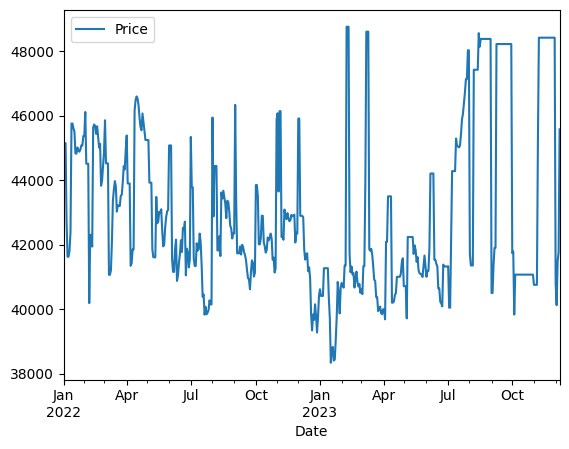

In [ ]:
plt.figure(figsize=(12,6))
data.plot()
plt.show()

,Price
count,504.000000
mean,43048.163472
std,2580.409711
min,38342.210000
25%,41126.155000
50%,42128.130000
75%,44887.110000
max,48764.550000


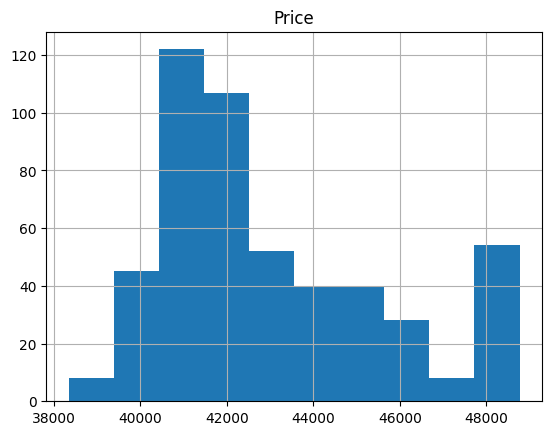

In [ ]:
data.hist()
data.describe()

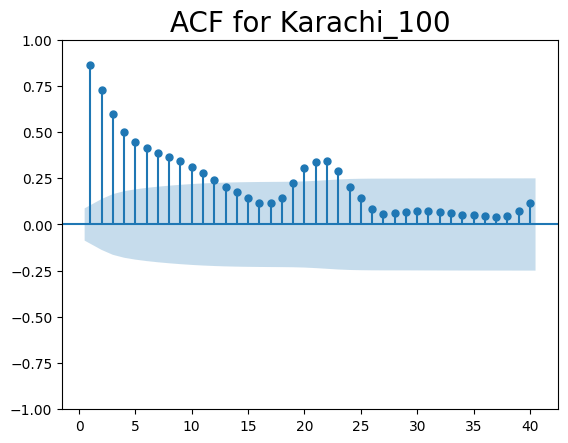

In [ ]:
sgt.plot_acf(data['Price'], zero = False, lags = 40)
plt.title("ACF for Karachi_100", size = 20)
plt.show()

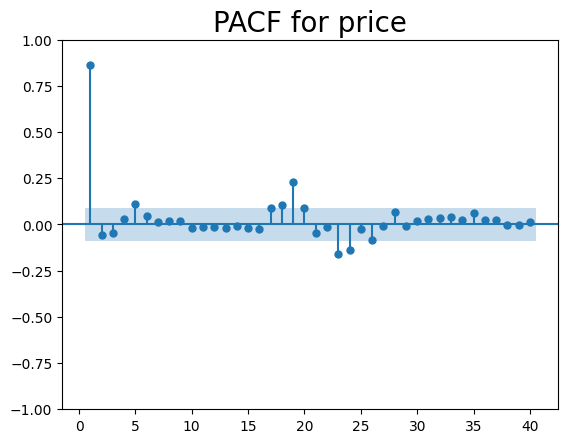

In [ ]:
sgt.plot_pacf(data['Price'], lags = 40, alpha = 0.05, zero = False)
plt.title("PACF for price", size = 20)
plt.show()

#ADF test for check the series stationary or not stationary

In [ ]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(data)
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key ,value in results[4].items():
  print('\t%s: %.3f' % (key, value))

if results[1]>0.05:
  print('Series is not Stationary')
else:
  print("Series is stationary")

ADF Statistic: -2.106992
p-value: 0.241712
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
Series is not Stationary


#plot trend, seasons, error

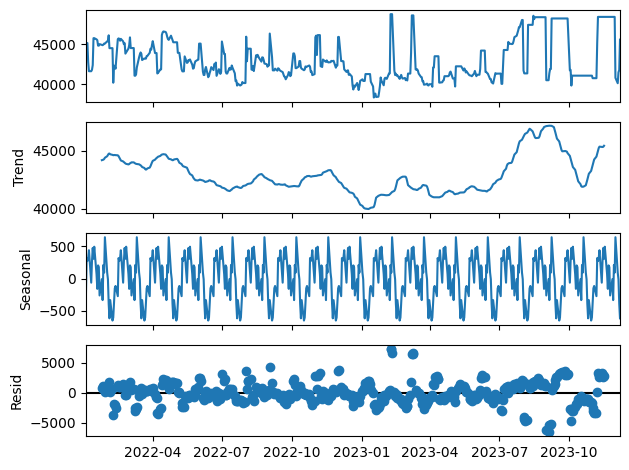

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = data
result = seasonal_decompose(series, model='additive',period=30)
result.plot()
pyplot.show()

#dataset split into train and test

In [ ]:
size = int(len(data)*0.8)
df, df_test = data.iloc[:size], data.iloc[size:]

#create model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df,order=(1,1,1),seasonal_order=(3,1,1,30))

#fit the model

In [ ]:
results = model.fit()

#prediction and check the accuracy or error

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
predictions = results.predict(start=len(df+1), end= len(df)+len(df_test)-1, dynamic=False)
#print(len(predictions))
#for i in range(len(predictions)):
#print('predicted=%f, expected=%f' % (predictions[i], df_test.ftse[i]))
rmse = sqrt(mean_squared_error(df_test.Price, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3696.766


In [ ]:
test=df_test

In [ ]:
test['prediction']=predictions

In [ ]:
test['difference']=test["Price"]-test['prediction']
print(test)

               Price    prediction   difference
Date                                           
2023-07-20  45426.58  45021.020444   405.559556
2023-07-21  45888.26  44980.153834   908.106166
2023-07-24  46065.55  45105.612889   959.937111
2023-07-25  46399.22  43537.042981  2862.177019
2023-07-26  46724.58  44238.834977  2485.745023
...              ...           ...          ...
2023-12-01  40803.89  46205.469864 -5401.579864
2023-12-04  40126.05  45154.343223 -5028.293223
2023-12-05  41487.58  45079.321267 -3591.741267
2023-12-06  41772.33  44945.244330 -3172.914330
2023-12-07  45581.13  44843.395651   737.734349

[101 rows x 3 columns]


#plot actual price and prediction price

In [ ]:
df = pd.DataFrame({'Actual': test.Price, 'Predicted': test.prediction})

<Axes: xlabel='Date'>

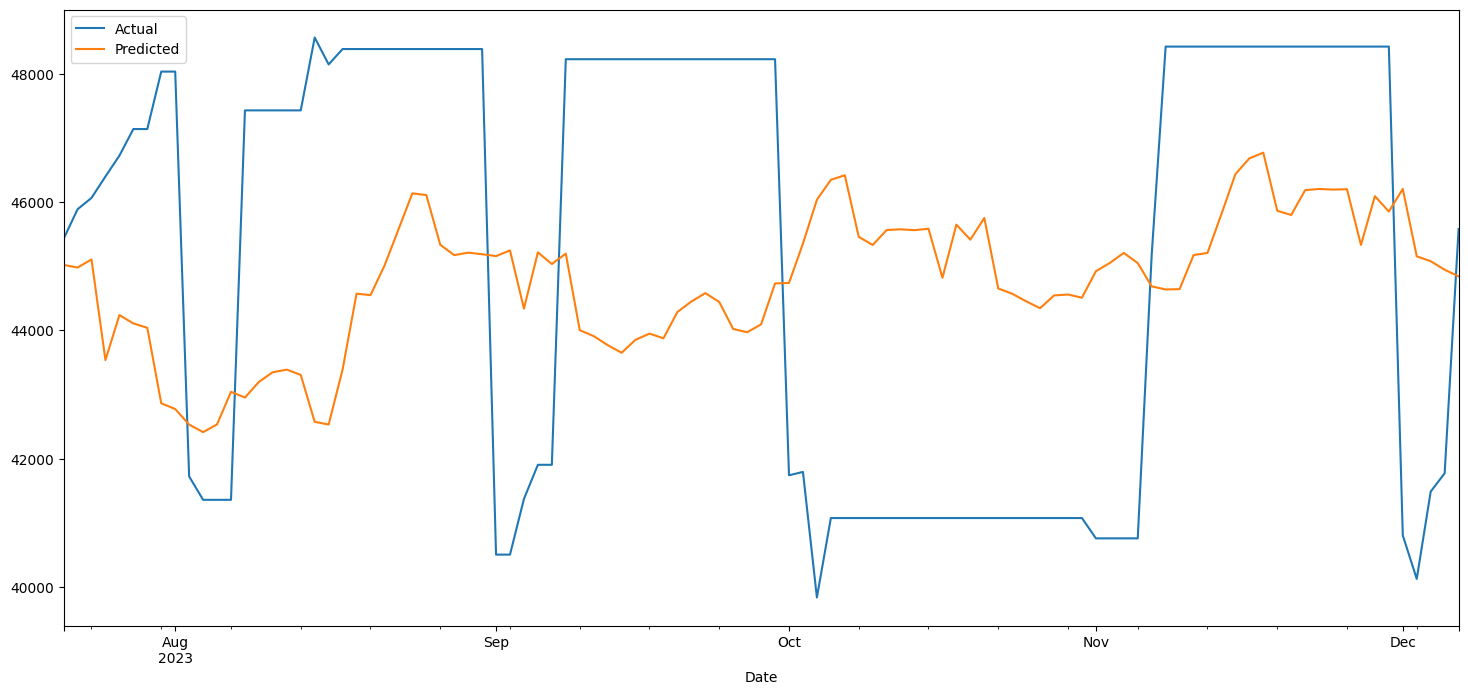

In [ ]:
df.plot(kind='line',figsize=(18,8))

In [ ]:
def train_test_split(data, n_train):
    return data[0:n_train], data[n_train:]

#tuning the model for bet model prediction

In [ ]:
def evaluate_arima_model(data, arima_order, train_data_size_percent = 0.8):
  # prepare training dataset
    train_size = int(len(data) * train_data_size_percent)
    train, test = train_test_split(data, train_size)
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error, test, predictions

In [ ]:
mse, test, predictions = evaluate_arima_model(data['Price'], arima_order=(2, 1, 1))

In [ ]:
print("RMSE :",sqrt(mse))

RMSE : 1797.253700561972


In [ ]:
final=pd.DataFrame({"Actual":test,"Forecast":predictions},index=test.index)

In [ ]:
final

,Actual,Forecast
Date,,
2023-07-20,45426.58,44931.250594
2023-07-21,45888.26,45275.827220
2023-07-24,46065.55,45719.444997
2023-07-25,46399.22,45886.744808
2023-07-26,46724.58,46223.295903
...,...,...
2023-12-01,40803.89,48327.540718
2023-12-04,40126.05,40913.885328
2023-12-05,41487.58,40631.840046


#plot actual and predict forcasting

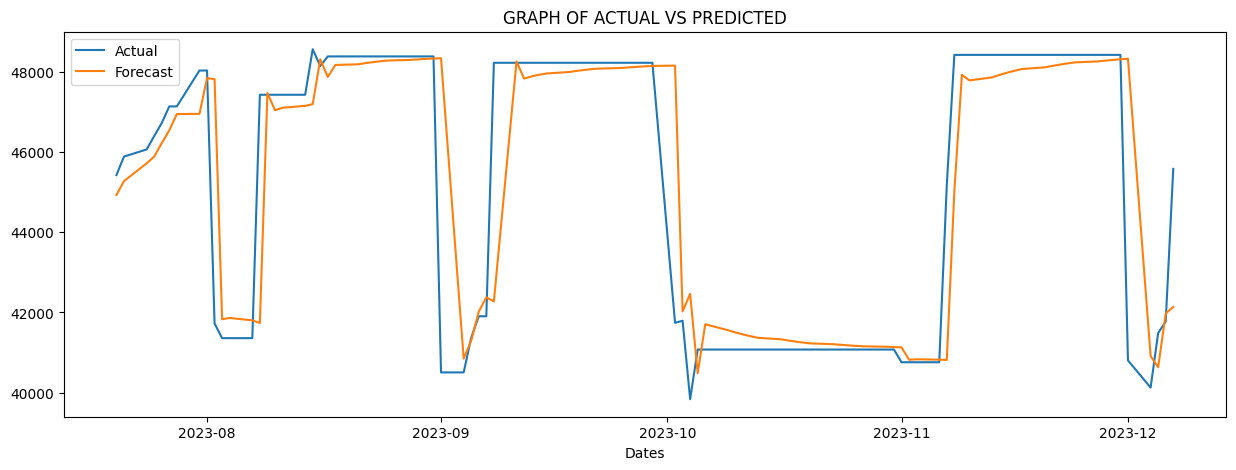

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(final.Actual, label='Actual')
plt.plot(final.Forecast, label = "Forecast")
plt.xlabel('Dates')
plt.title('GRAPH OF ACTUAL VS PREDICTED')
plt.legend()
plt.show()